In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from scipy import stats
import statsmodels.api as sm

In [ ]:
# data loading
df_og = pd.read_csv('/kaggle/input/kaggle-survey-2021/kaggle_survey_2021_responses.csv')

df_pop = pd.read_csv('/kaggle/input/population-by-country-2021/2021_country_populations.csv', 
                     encoding='Latin-1')

df_pop['Country (or dependency)'].replace({'Czech Republic (Czechia)':'Czech Republic'}, inplace=True)


# remove questions
df = df_og.iloc[1:, :].copy()


# create ID column
df['ID'] = df.index


# map to convert earnings bins to midpoint
earnings_map = {
 '$0-999': 500,
 '100,000-124,999': 112500,
 '10,000-14,999': 12500,
 '1,000-1,999': 1500,
 '40,000-49,999': 45000,
 '30,000-39,999': 35000,
 '50,000-59,999': 55000,
 '5,000-7,499': 6250,
 '15,000-19,999': 17500,
 '70,000-79,999': 75000,
 '60,000-69,999': 65000,
 '20,000-24,999': 22500,
 '150,000-199,999': 175000,
 '7,500-9,999': 8650,
 '125,000-149,999': 137500,
 '2,000-2,999': 2500,
 '25,000-29,999': 27500,
 '90,000-99,999': 95000,
 '80,000-89,999': 85000,
 '4,000-4,999': 4500,
 '3,000-3,999': 3500,
 '200,000-249,999': 225000,
 '300,000-499,999': 400000,
 '250,000-299,999': 275000,
 '$500,000-999,999': 750000,
 '>$1,000,000': 1200000
}

df['earnings'] = df['Q25'].replace(earnings_map)

cost = pd.read_csv('/kaggle/input/cost-of-living-index-by-country-numbeo-2021/2021_cost_of_living_rankings_by_country.csv')

cost = cost[['Country', 'Cost of Living Index']]

USA_coli = cost[cost['Country']=='United States']['Cost of Living Index'].values[0]

# change kaggle countries to match numbeo index
name_changes = {'Hong Kong (S.A.R.)' : 'Hong Kong',
 'Iran, Islamic Republic of...' : 'Iran',
 'United Kingdom of Great Britain and Northern Ireland' : 'United Kingdom',
 'United States of America' : 'United States',
 'Viet Nam' : 'Vietnam'}

df['Q3'] = df['Q3'].replace(name_changes)

# getting normalized earnings
df = df.merge(cost, how='left', left_on='Q3', right_on='Country')
df['earnings_norm'] = (
    df['earnings'] / df['Cost of Living Index']
) 

df['earnings_norm_US'] = df['earnings_norm'] * USA_coli


# age mapping
age_mapping = {
    '18-21' : 19.5,
    '22-24' : 23,
    '25-29' : 27,
    '30-34' : 32,
    '35-39' : 37,
    '40-44' : 42,
    '45-49' : 47,
    '50-54' : 52,
    '55-59' : 57,
    '60-69' : 64.5,
    '70+' : 75
}

df['Q1_num'] = df['Q1'].replace(age_mapping)


# education mapping
edu_mapping = {
    'Master’s degree' : 6,
    'Bachelor’s degree' : 4,
    'Doctoral degree' : 10,
    'Some college/university study without earning a bachelor’s degree' : 2,
    'I prefer not to answer' : 0,
    'No formal education past high school' : 0,
    'Professional doctorate' : 10
}

df['Q4_num'] = df['Q4'].replace(edu_mapping)


# years coding mapping
years_coding_mapping = {
    '1-3 years' : 2,
    '10-20 years' : 15,
    '20+ years' : 25,
    '3-5 years' : 4,
    '5-10 years' : 7.5,
    '< 1 years' : 0.5,
    'I have never written code' : 0
}

df['Q6_num'] = df['Q6'].replace(years_coding_mapping)


# ML mapping
ML_mapping = {
    'Under 1 year' : 0.5,
    '1-2 years' : 1.5,
    'I do not use machine learning methods' : 0,
    '2-3 years' : 2.5,
    '3-4 years' : 3.5,
    '5-10 years' : 7.5,
    '4-5 years' : 4.5,
    '10-20 years' : 15,
    '20 or more years' : 25
}

df['Q15_num'] = df['Q15'].replace(ML_mapping)


# shorten Q24 answers
og_strings = ['Analyze and understand data to influence product or business decisions',
'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
'Build prototypes to explore applying machine learning to new areas',
'Build and/or run a machine learning service that operationally improves my product or workflows',
'Experimentation and iteration to improve existing ML models',
'Do research that advances the state of the art of machine learning',
'None of these activities are an important part of my role at work']

shortened_strings = [
    'Analyze data for business decisions',
    'Build the data infrastructure',
    'Build ML prototypes in new areas',
    'Build ML services for products/workflows',
    'Improving existing ML models',
    'Research to advance ML',
    'None']

replace_dict = dict(zip(og_strings, shortened_strings))

for col in [col for col in df.columns if 'Q24' in col]:
    df[col].replace(replace_dict, inplace=True)


# shorten Q40 answers
Q40_part9_map = {'Cloud-certification programs (direct from AWS, Azure, GCP, or similar)':
                 'Cloud-certification'}
df['Q40_Part_9'].replace(Q40_part9_map, inplace=True)

Q40_part10_map = {'University Courses (resulting in a university degree)':
                  'University Courses'}
df['Q40_Part_10'].replace(Q40_part10_map, inplace=True)



# shorten Q11 answers
Q11_map = {
    'A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)':
        'A Deep learning workstation',
    'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)':
        'A cloud computing platform'
}

df['Q11'].replace(Q11_map, inplace=True)

# **1. Introduction to _Kaggle Online_**

Welcome to **_Kaggle Online_**! 

**_Kaggle Online_** is an Online Role-Playing Game (RPG) where you play out your career as a data professional.

<div class="alert alert-block alert-info"> 📌 A <i>professional</i> is anyone who didn't respond "Student" or "Currently not employed" to <code>Q5: Select the title most similar to your current role</code>.</div>

<br>

***Kaggle Online*** has a rich character customization and career progression system. There's too much to cover in one guide, but this guide will cover the following insights and functionality:

- (2) What is an "Analyst?"
    - (2.1) Job Title
    - (2.2) Split Responsibilities
- (3) Character Creation
    - (3.1) Age
    - (3.2) Location
    - (3.3) Industry
- (4) Skill Points
    - (4.1) Formal Education
    - (4.2) Coding Experience
    - (4.3) Machine Learning Experience
    - (4.4) Online Education
- (5) Class System
    - Language-agnostic
- (6) Equipment
    - (6.1) Computing Platform
    - (6.2) IDE
    - (6.3) Visualization Libraries
    - (6.4) Machine Learning Libraries
    - (6.5) Business Intelligence Tools
- (7) Inventory
    - ???
 
This is a comprehensive guide to getting started in **_Kaggle Online_** as an **analyst**. What exactly is an "analyst", you might ask? Let's dive in.

In [ ]:
# get all professionals
df_p = df[~(df['Q5'].isin(['Student', 'Currently not employed']))].copy()


# get data professionals
df_data_p = df_p[
    ~(df_p['Q24_Part_1'].isnull()) | ~(df_p['Q24_Part_2'].isnull()) | ~(df_p['Q24_Part_3'].isnull()) | 
    ~(df_p['Q24_Part_4'].isnull()) | ~(df_p['Q24_Part_5'].isnull()) | ~(df_p['Q24_Part_6'].isnull())          
].copy()

print(f'Number of survey responses: {df.shape[0]}')
print(f'Number of "professionals": {df_p.shape[0]}')
print(f'Number of "data professionals": {df_data_p.shape[0]}')
print(f'Number of non-data professionals: {df_p.shape[0]-df_data_p.shape[0]}')

# **2. What is an "Analyst"?**

Playing **_Kaggle Online_** as a Data Analyst or Data Scientist is relatively straightforward, as the Kaggle Survey Data explicitly defines those job titles in `Q5`. That's not what this guide is for.

Both of those job titles, along with many others, are *umbrella terms* that encompass a wide range of workflows and functions. This guide, then, more specifically defines an "analyst" as someone whose **primary work is analytical**: they can have supporting workflows, but their foremost goal or responsibility should be to *drive decisions by analyzing data*. 

## **2.1 Indentifying Analysts** 

The survey is extensive, but there are two key questions that will be used to identify an analyst:

1. `Q5: Select the title most similar to your current role (or most recent title if retired):`
2. `Q24: Select any activities that make up an important part of your role at work:`

By looking at the job title closest to an individual's role in their company as well as the activities that make up an important part of their role, we can get a pretty good idea of whether their primary work is analytical.

<div class="alert alert-block alert-info"> 📌 Each record in the Kaggle Survey Data is a successful player on <b><i>Kaggle Online</i></b>. By isolating the "analyst" players and analyzing how they've played + comparing them to non-analysts, this guide will outline how to successfully play as an analyst in <b><i>Kaggle Online</i></b>.</div>

<br>

`Q24`'s first answer choice is very telling: `Analyze and understand data to influence product or business decisions`

This response almost exactly matches our definition of analyst, so we can start the search for analyst players by filtering professionals for individuals that selected this answer. We're down to 9108 analysts.

In [ ]:
df_analyst = df_p[~df_p['Q24_Part_1'].isnull()]

print(f'Number of analysts: {df_analyst.shape[0]}')

This is a good start, but it's unlikely that over half of data professionals have analytical work as their primary task, especially considering the wide range of job titles, from `Research Scientist` to `Software Engineer`. We'll have to narrow it down further.

## **2.2 Job Title**

Despite the fact that some individuals with every job title selected the answer to Q24 that we're looking for, not all responses are created equal. Q24 is a multi-select question, and there's no indication of order or priority. Considering that some individuals selected all 6 options (NEED TO CHECK THIS), we're going to have to make some assumptions. 

Intuitively, we can understand that certain job titles that are less likely to meet our requirements for an analyst; if an player identifies as a `Data Analyst`, for example, they're much more likely to have analytical work as their primary task than a `Software Engineer`. 

To quantify these differences, we can take a look at the proportion of *professionals* in each job title that selected the first answer choice of Q24.


In [ ]:
Q24_df = df_p[['Q24_Part_1', 'Q5']].copy()
Q24_df['Q24_Part_1'] = Q24_df['Q24_Part_1'].apply(lambda x: True if type(x)==str else False)

Q24_df_grouped = (
    Q24_df
    .groupby('Q5')
    .agg(
        sum=('Q24_Part_1', 'sum'),
        count=('Q24_Part_1', 'count')
    )
    .reset_index()
)

Q24_df_grouped['pct'] = Q24_df_grouped['sum'] / Q24_df_grouped['count']

Q24_df_grouped = Q24_df_grouped.sort_values('pct')



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Prevalence of Analytical Work</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of individuals in each field that selected option 1 for Q24</span>
'''

fig = px.bar(
    Q24_df_grouped, 
    x='pct', y='Q5', orientation='h', 
    title=title,
    # title='<b>Percentage of jobs performing analytical work<b><br><sup>subtitle</sup>',
    labels={'Q5':'Job Title', 'pct':'Percentage'}, text='pct'
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [base_color]*10 + [highlight_color]*3)
)
fig.update_layout(
    xaxis={'tickformat':'.0%', 'title':''},
    yaxis={'title':''},
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.show()

In [ ]:
# checking pareto principle
pareto_pct = Q24_df_grouped.tail(3)['sum'].sum() / Q24_df_grouped['sum'].sum()
top_3_prop = 3/13
print(f'Top 3 jobs ({top_3_prop:.2f}) make up {pareto_pct:.2f} of analysts')

There seems to be a natural drop-off point after `Data Scientist`; a cutoff here also aligns somewhat with the *Pareto Principle*, as these top three (\~23%) of job titles compose the majority (\~53%) of our currently selected subset. 

These job titles should also make intuitive sense: if an individual identifies as a `Data Analyst`, `Business Analyst`, or `Data Scientist`, you can easily see how their primary focus would be analytical work, where you'd be hard-pressed to say the same for a `Product Manager`, `Data Engineer`, or `Research Scientist`.

After filtering for those three job titles, we're left with 4794 candidate analysts.

In [ ]:
df_analyst = df_analyst[df_analyst['Q5'].isin(['Data Analyst', 'Business Analyst', 'Data Scientist'])]
print(f'Number of analysts: {df_analyst.shape[0]}')

## **2.3 Split Responsibilities**

We've narrowed it down significantly, but we haven't done anything to consider that many of these individuals also selected responses to Q24 that *aren't* the first option, and there's no indication of relative importance or priority in the data. Let's look at the remaining choices:

> 2. Build and/or run the data infrastructure that my business uses for storing, analyzing, and
operationalizing data
3. Build prototypes to explore applying machine learning to new areas
4. Build and/or run a machine learning service that operationally improves my product or
workflows
5. Experimentation and iteration to improve existing ML models
6. Do research that advances the state of the art of machine learning

\**(choices that have already been filtered out are not present)*

Option 2 could feasibly be performed by someone whose primary task is analytical, such as if they have to help create or modify data infrastructure in order to get access to the data they need to analyze. Option 3 could also feasibly be performed by someone whose primary goal is analytical, such applying a base model as part of an analysis to make a decision for or against ML investment in a certain area. Both of these tasks could be performed by a technically advanced analyst who's more end-to-end in their analysis. 

However, Options 4, 5, and 6 require a much more intricate knowledge of complex machine learning, seem less likely to be supporting an analytical workflow, and are tasks that at most companies have dedicated employees for. Thus, we're going to filter out any individuals that selected options 4, 5, or 6 in Q24.

In [ ]:
df_analyst = df_analyst[
           (df_analyst['Q24_Part_4'].isnull()) & 
           (df_analyst['Q24_Part_5'].isnull()) & 
           (df_analyst['Q24_Part_6'].isnull())
]

# proportions
DA_pct = df_analyst[df_analyst['Q5']=='Data Analyst'].shape[0] / df_p[df_p['Q5']=='Data Analyst'].shape[0]
BA_pct = df_analyst[df_analyst['Q5']=='Business Analyst'].shape[0] / df_p[df_p['Q5']=='Business Analyst'].shape[0]
DS_pct = df_analyst[df_analyst['Q5']=='Data Scientist'].shape[0] / df_p[df_p['Q5']=='Data Scientist'].shape[0]


df_display = pd.DataFrame()
df_display['Field Name'] = ['Final # of analysts', '# Professionals', '# Non-data Professionals',
                            '% of professionals selected', '% of Data Analysts selected', 
                            '% of Business Analysts selected', '% of Data Scientists Selected']
df_display['Field Quantity'] = [int(df_analyst.shape[0]), 
                                int(df_p.shape[0]),
                                int(df_p.shape[0]-df_data_p.shape[0]),
                                '{:.2%}'.format(df_analyst.shape[0]/df_p.shape[0]), 
                               '{:.2%}'.format(DA_pct), 
                                '{:.2%}'.format(BA_pct), 
                                '{:.2%}'.format(DS_pct)]

df_display

Ultimately, we're left with 2508 analysts out of 17183 professionals. We selected ~52% of data analysts and business analysts and ~22% of data scientists. These percentages might seem low at first, but consider:
- 4916 professionals don't work with data at all.
- **_Kaggle Online_** has a high concentration of players that are focused on machine learning (as opposed to analytical work), regardless of job title, due to the prevalence of ML competitions and content on **_Kaggle Online_**.

Now that we've identified the analysts, it's time to get started with **_Kaggle Online_**!

In [ ]:
# role specific dataset
df_DA = df_analyst[df_analyst['Q5']=='Data Analyst'].copy()
df_BA = df_analyst[df_analyst['Q5']=='Business Analyst'].copy()
df_DS = df_analyst[df_analyst['Q5']=='Data Scientist'].copy()

# creating a dataset for analysts and non-analysts
analyst_index = df_analyst.index
df_other = df_p[~df_p.index.isin(analyst_index)].copy()

# check that shape works out
print(df_p.shape[0])
print(df_analyst.shape[0])
print(df_other.shape[0])
print(df_analyst.shape[0] + df_other.shape[0])

# create a dataset with all individuals and an "Analyst?" identifier column
df_analyst['Analyst?'] = True
df_other['Analyst?'] = False
df_all = df_analyst.append(df_other)

# cast "Analyst?" as 0/1 for use in simple regression modeling
df_regression = df_all.copy()
df_regression['Analyst_num'] = df_regression['Analyst?'].astype(int)

# **3. Character Creation**

Before you can enter **_Kaggle Online_**, you'll need to create a character. As mentioned in the introduction, there are three key decisions to make during character creation:

1. Age
2. Location
3. Industry

This guide looks at the distribution of these attributes among successful analyst players and compares it to non-analyst players to aid the decision.

## **3.1 Age**

Age is an important attribute to consider: too young, and XXX; too old, and YYY. 

The chart below shows the distribution of age for analysts and non-analysts.

In [ ]:
analyst_age_pct = df_analyst.groupby(['Q1']).agg(count=('ID', 'count')).reset_index()
other_age_pct = df_other.groupby(['Q1']).agg(count=('ID', 'count')).reset_index()

analyst_count, other_count = df_analyst.shape[0], df_other.shape[0]

analyst_age_pct['pct'] = analyst_age_pct['count'] / analyst_count
other_age_pct['pct'] = other_age_pct['count'] / other_count

analyst_age_pct['pct_string'] = analyst_age_pct['pct'].apply(lambda x: '{:.2%}'.format(x))
other_age_pct['pct_string'] = other_age_pct['pct'].apply(lambda x: '{:.2%}'.format(x))


# all_pct = pd.concat([analyst_age_pct, other_age_pct], axis=)
all_pct = analyst_age_pct.merge(other_age_pct, on='Q1', how='left', suffixes=('_analyst', '_other'))

all_pct_plot = all_pct[['Q1', 'pct_analyst', 'pct_other']].sort_values('Q1', ascending=False)

all_pct_plot = all_pct_plot.set_index('Q1')


# print means and medians
print(f"Analyst mean age: {df_analyst['Q1_num'].mean()}")
print(f"Non-analyst mean age: {df_other['Q1_num'].mean()}")

print(f"Analyst median age: {df_analyst['Q1_num'].median()}")
print(f"Non-analyst median age: {df_other['Q1_num'].median()}")

print(stats.ttest_ind(df_analyst['Q1_num'], df_other['Q1_num']))


# actual plot
sns.set(rc={'figure.facecolor':'beige', 'axes.facecolor':'beige'})
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(all_pct_plot, cmap=colormap, annot=True, fmt='.1%', ax=ax)

for i in range(all_pct_plot.shape[0]+1):
    ax.axvline(i, color='beige', lw=50)

# the y of these lines isn't 100% accurate because of weird boundaries in the ranges
ax.axhline(7.5, xmin=0.05, xmax=0.45, color='red')
ax.axhline(7, xmin=0.55, xmax=0.95, color='red')

plt.yticks(rotation=360)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

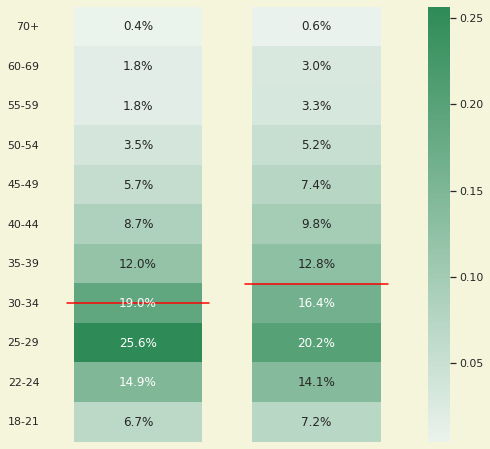

THIS IMAGE IS A PLACEHOLDER NEED TO ANNOTATE IT ON GOOGLE SLIDES AND THEN REUPLOAD

As you can see, analysts are slightly younger than non-analysts, with an average age of 32.77 years old (1.62 years younger than non-analysts). Analysts have a similar or larger percentage of individuals in the younger age groups from 18-34, and then a smaller percentage all the way from 35-70+. 

Keeping the above results in mind, this guide recommends setting your character's age to 32.

## **3.2 Location**

Location is key in **_Kaggle Online_**, as it impacts many other recorded and unrecorded attributes, such as salary and technological development. You can't choose your character's location outright; instead, you submit a priority list and receive one of your choices based on overall demand.

The map below shows the number of survey respondents that were identified to be analysts in each country divided by that country's overall population. The result was multiplied by 1,000,000 and dubbed `Metric` because the number of survey respondents is very small compared to country populations.

In [ ]:
df_pop['Population_num'] = df_pop['Population'].str.replace(',', '')
df_pop['Population_num'] = df_pop['Population_num'].astype(float)

df_analyst_location = df_analyst.groupby('Q3').agg(count=('ID', 'count')).reset_index()
df_analyst_location = df_analyst_location.merge(df_pop, how='left', left_on='Q3', right_on='Country (or dependency)')
df_analyst_location['metric'] = df_analyst_location['count'] / df_analyst_location['Population_num'] * 1000000


# the actual plot
title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Analyst vs. Population by Country</span><br>
<span style='font-size:13px; font-family:Helvetica'>Color represents the # of analysts that responded in a country / population * 1M (for scaling)</span>
'''

fig = px.choropleth(
    df_analyst_location, locations='Q3', color='metric', 
    locationmode='country names',
    title = title, hover_data=['count'],
    labels={'metric':'Metric', 'count':'# of Analysts'},
    color_continuous_scale='greens'
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

You should expect countries that have a higher `Metric` value to be easier servers for your character to play in, since the analyst environment is theoretically riper. `Metric` isn't perfect, since the survey probabily isn't a representative sample of the world's population and more technologically developed countries may be overrepresented. However, large countries such as India, Brazil, and China have a realtively high number of survey responses, so it hopefully isn't too biased. 

Countries that stand out to be added to your character's priority list are Australia, Greece, Canada, Portugal, United Kingdom, and the Netherlands. The most promising of these are the United Kingdom, Australia, and Canada, since they have all have `Metric` values above 1.0 and a relatively sizable number of absolute analyst responses (77, 46, 45). The United States is also notable, with 297 analysts and a `Metric` of 0.897.

## **3.3 Industry**

Less important than location, industry is still an important attribute that affects salary, company demographics, and more. Similar to location, you submit a priority list for industry as opposed to choosing outright. Industry assignment is based on overall demand.

The chart below shows the percentage of individuals in each industry for analysts and non analysts.

In [ ]:
df_industry = (
    df_all
    .groupby(['Analyst?'])
    ['Q20']
    .value_counts(normalize=True)
    .to_frame()
    .rename(columns={'Q20':'pct'})
    .reset_index()
    .sort_values('pct')
)

df_industry['Q20'] = df_industry['Q20'].apply(
    lambda x: x.split('/')[0]
)


# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Distribution of Company Industry</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts and non-analysts in each industry</span>
'''

fig = px.bar(
    df_industry, 
    x='pct', y='Q20', orientation='h',
    title=title,
    facet_col='Analyst?',
    labels={'Q20':'Industry', 'pct':'Percentage'}, text='pct',
    height=700,
    category_orders={'Analyst?':[True, False]}
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [base_color]*15 + [highlight_color]*3)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(tickformat='.0%', title='')
fig.update_yaxes(title='')

fig.show()

The y-axis is in descending order for Analysts, and looking at the bars for non-analysts the order of industries is quite similar, with the top four as `Computers/Technology`, `Academics/Education`, `Accounting/Finance`, and `Other` for both groups. 

Interestingly, non-analysts seem to be much more biased towards the top, with a much higher concentration of non-analysts in Computers and Academics and a lower concentration in Accounting, as well as analysts being slightly more even throughout the rest of the distribution. This makes sense, given the previously defined criteria for analysts relating to ML work; computers(/technology) and academics(/education) are the industries that push the edge of machine learning, so it makes sense that non-analysts would have a higher concentration in those areas.

In terms of your character, you should still prioritize `Computers/Technology` and `Academics/Education`, but `Accounting/Finance` also becomes a strong option and you should have slightly more ease playing through any industry you want as compared to the rest of the **_Kaggle Online_** playerbase.

# **4. Skill Points**

At this point, your character should be created!

Upon character creation, you'll be awarded a number of initial **skill points** (SP). You need these to be a successful analyst; without them, your character won't have the skills necessary to analyze data and make decisions. As outlined in the introduction, **skill points** can be spent in four key areas:

1. Formal Education
2. Coding Experience
3. Machine Learning Experience
4. Online Education

Most players spend all of their SP across these four areas. There are, however, hidden skills not shown in the survey where unused SP can be spent. Analyst vs. non-analyst SP distribution will be analzyed to examine how you should distribute your SP and whether to save some for hidden skills.



## **4.1 Formal Education**

There are various options for how much a character can be formally educated, from nothing past high school to a doctoral degree. The chart below shows the distribution of formal education levels for analysts and non-analysts.

In [ ]:
df_edu_analyst = (
    df_analyst['Q4']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q4':'pct', 'index':'Level of Education'})
)
df_edu_analyst['Analyst?'] = True

df_edu_other = (
    df_other['Q4']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q4':'pct', 'index':'Level of Education'})
)
df_edu_other['Analyst?'] = False

df_edu_all = df_edu_analyst.merge(df_edu_other, how='left', on='Level of Education', suffixes=('_analyst', '_other'))

df_edu_all['Analyst %'] = df_edu_all['pct_analyst'].apply(lambda x: '{:.2%}'.format(x))
df_edu_all['Non-analyst %'] = df_edu_all['pct_other'].apply(lambda x: '{:.2%}'.format(x))

df_display = df_edu_all.iloc[[4, 5, 3, 1, 0, 6, 2], :].reset_index(drop=True)
df_display[['Level of Education', 'Analyst %', 'Non-analyst %']]

From this table, you can see that:
- Analysts are slightly more likely to have a Bachelor's or Master's degree, but much less likely (<0.5x) to have a doctoral degree.
- The majority (~83%) of analysts have either a Bachelor's or Master's degree.
- Analyst positions are more accessible than non-analyst ones if you don't finish your college degree, with 1.3x the proportion of players having some university study without graduating.

To analyze education more quantitatively, this guide maps each education level to the average number of years it takes to complete that level of education, starting with high school graduation as 0 years. Analysts take 0.46 fewer years of education, on average, than non-analysts. Analysts are younger, however, and that might have an effect on education; a simple regression model reveals that analysts take 0.37 fewer years of education when controlling for age. 

Despite both of these quantities being statistically significant, they aren't very large, as the difference between different levels of education is at least 2 years. Thus, you should invest a normal amount of SP in formal education for your character, leading to either a Bachelor's or Master's degree.

In [ ]:
analyst_mean = df_analyst['Q4_num'].mean()
other_mean = df_other['Q4_num'].mean()

print(f'Analyst mean: {analyst_mean}')
print(f'Non-analyst mean: {other_mean}')
print(stats.ttest_ind(df_analyst['Q4_num'], df_other['Q4_num']))


# regression without controlling for age
X = df_regression[['Analyst_num']]
y = df_regression['Q4_num']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())


# regression with controlling for age
X = df_regression[['Analyst_num', 'Q1_num']]
y = df_regression['Q4_num']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())

## **4.2 Coding Experience**

Coding experience is a hugely important attribute to consider for your character, because a large portion of a professional's work (including analysts) may consist of coding. 

The chart below compares the distribution of coding experience for analysts and non-analysts.

In [ ]:
df_coding_analyst = (
    df_analyst['Q6']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q6':'pct', 'index':'Years Coding'})
)
df_coding_analyst['Analyst?'] = True

df_coding_other = (
    df_other['Q6']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q6':'pct', 'index':'Years Coding'})
)
df_coding_other['Analyst?'] = False


df_coding_all = df_coding_analyst.merge(df_coding_other, how='left', on='Years Coding', suffixes=('_analyst', '_other'))
df_coding_all['Years Coding'].replace({'I have never written code':'0 years'}, inplace=True)
df_coding_all.rename(columns={'pct_analyst':'% Analyst', 'pct_other':'% Non-analyst'}, inplace=True)


df_coding_plot = df_coding_all[['Years Coding', '% Analyst', '% Non-analyst']].set_index('Years Coding')
df_coding_plot = df_coding_plot.loc[['20+ years', '10-20 years', '5-10 years',
                                     '3-5 years', '1-3 years', '< 1 years',
                                     '0 years'], :]


# finding + printing means
print(f"Analyst average years of coding experience: {df_analyst['Q6_num'].mean()}")
print(f"Non-analyst average years of coding experience: {df_other['Q6_num'].mean()}")
# strong evidence that there's a significant difference in coding experience
print(stats.ttest_ind(df_analyst['Q6_num'], df_other['Q6_num']))


# actual plot
sns.set(rc={'figure.facecolor':'beige', 'axes.facecolor':'beige'})
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df_coding_plot, cmap=colormap, annot=True, fmt='.1%', ax=ax)

for i in range(all_pct_plot.shape[0]+1):
    ax.axvline(i, color='beige', lw=50)

# the y of these lines isn't 100% accurate because of weird boundaries in the ranges
ax.axhline(3.4, xmin=0.05, xmax=0.45, color='red')
ax.axhline(2.55, xmin=0.55, xmax=0.95, color='red')

plt.yticks(rotation=360)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

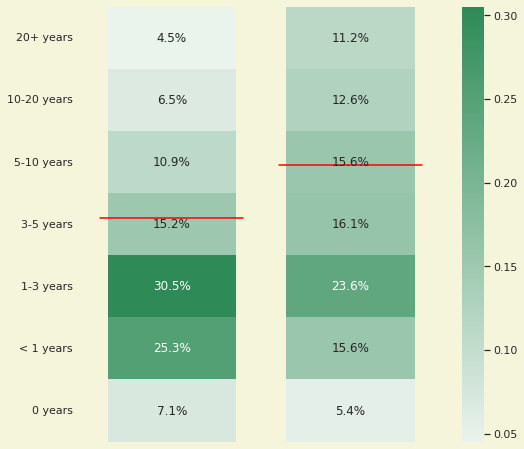

PLACEHOLDER IMAGE NEEDS TO BE ANNOTATED + REPLACED LATER

You can see that
- More than half of analysts have been coding for three years or less (~63%), while the same can be said for only ~47.7% of non-analysts.
- 1.45x as many analysts have never written code as compared to non-analysts (aka more accessible)
- Over twice as many (2.3x) non-analysts have written code for 20+ years than analysts.

Unlike education, when you take the midpoint of each range and do a quantitative analysis, there's a pretty significant difference (2.36 years) in coding experience between analysts and non-analysts. This could potentially be due to the fact that analysts are younger and have slightly fewer years of education (on average), but a simple linear regression model shows that even when controlling for these factors, analysts have 1.67 fewer years of coding experience. Whether you *want* to control for these factors is another discussion beyond the scope of this guide.

In [ ]:
analyst_mean = df_analyst['Q6_num'].mean()
other_mean = df_other['Q6_num'].mean()

print(f'Analyst mean: {analyst_mean}')
print(f'Non-analyst mean: {other_mean}')
print(stats.ttest_ind(df_analyst['Q6_num'], df_other['Q6_num']))


# regression without controlling for age
X = df_regression[['Analyst_num']]
y = df_regression['Q6_num']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())


# regression with controlling for age
X = df_regression[['Analyst_num', 'Q1_num', 'Q4_num']]
y = df_regression['Q6_num']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())

All of these findings make sense, for a couple of reasons. Within the dataset, analysts don't have complex ML tasks as an important part of their work, so they might not need as much coding experience. Additionally, as described by Benn Stancil in [this article](https://benn.substack.com/p/analytics-is-at-a-crossroads), being an analytical thinker and performing analytical work goes beyond the coding requirements. Although the problem he describes is still alive and well, it's cool to see some of the sentiment about what should qualify someone as an "analyst" reflected in the survey.

With the ~2 years worth of SP that you've saved on coding experience, you should consider putting SP in one of the following hidden areas:
- Additional Bachelor's or Master's degrees in textured, complex areas, such as urban demography
- Formal or online education in narration/writing to improve influence on decisions
- Bonus work experience in a non-data field

## **4.3 Machine Learning Experience**

In addition to general coding experience, you can also invest SP specifically in machine learning. 

While this may be less necessary based on our criteriafor an "analyst", building simple models (like the one this guide uses above) or more complex prototypes can be an important part of analytical work. 

The chart below shows the distribution of machine learning experience for analysts and non-analysts.

In [ ]:
df_analyst_coding = df_analyst[(df_analyst['Q6'] != 'I have never written code')].copy()
df_analyst_coding.dropna(subset=[col for col in df_analyst.columns if 'Q15' in col], how='all', inplace=True)
df_other_coding = df_other[(df_other['Q6'] != 'I have never written code')].copy()
df_other_coding.dropna(subset=[col for col in df_other.columns if 'Q15' in col], how='all', inplace=True)


df_ML_analyst = (
    df_analyst_coding['Q15']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q15':'pct', 'index':'Years Using ML'})
)
df_ML_analyst['Analyst?'] = True

df_ML_other = (
    df_other_coding['Q15']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q15':'pct', 'index':'Years Using ML'})
)
df_ML_other['Analyst?'] = False


df_ML_all = df_ML_analyst.merge(df_ML_other, how='left', on='Years Using ML', suffixes=('_analyst', '_other'))
df_ML_all['Years Using ML'].replace({
    'I do not use machine learning methods':'0 years',
    '20 or more years':'20+ years', 'Under 1 year':'< 1 years'
    }, inplace=True)
df_ML_all.rename(columns={'pct_analyst':'% Analyst', 'pct_other':'% Non-analyst'}, inplace=True)


df_ML_plot = df_ML_all[['Years Using ML', '% Analyst', '% Non-analyst']].set_index('Years Using ML')
df_ML_plot = df_ML_plot.loc[['20+ years', '10-20 years', '5-10 years',
                             '4-5 years', '3-4 years', '2-3 years', '1-2 years',
                             '< 1 years', '0 years'], :]


# finding + printing means
print(f"Analyst average years of ML experience: {df_analyst_coding['Q15_num'].mean()}")
print(f"Non-analyst average years of ML experience: {df_other_coding['Q15_num'].mean()}")
# strong evidence that there's a significant difference in ML experience
print(stats.ttest_ind(df_analyst_coding['Q15_num'], df_other_coding['Q15_num']))


# actual plot
sns.set(rc={'figure.facecolor':'beige', 'axes.facecolor':'beige'})
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df_ML_plot, cmap=colormap, annot=True, fmt='.1%', ax=ax)

for i in range(all_pct_plot.shape[0]+1):
    ax.axvline(i, color='beige', lw=50)

# the y of these lines isn't 100% accurate because of weird boundaries in the ranges
ax.axhline(6.5, xmin=0.05, xmax=0.45, color='red')
ax.axhline(5.5, xmin=0.55, xmax=0.95, color='red')

plt.yticks(rotation=360)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

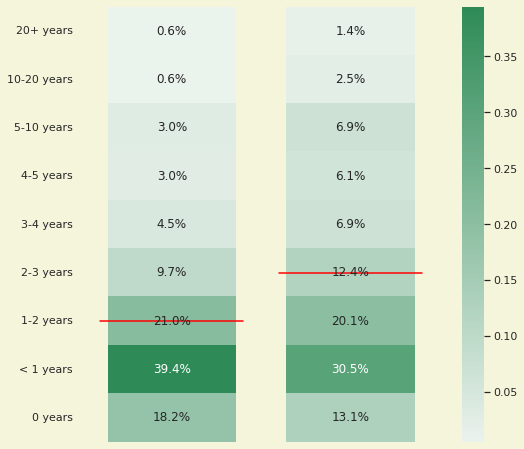

PLACEHOLDER IMAGE

You can see that:

- As expected, being an analyst is much more accessible, with analysts being nearly 2.5x more likely (~2.43x) to not use ML methods
- The vast majority (~88%) of analysts have used machine learning methods for 3 years or less
- On the high end, non-analysts are over 4x as likely (~4.18x) to have 10 years or more of ML experience

A quantitative analysis here also yields significant results: analysts have less than half as many years of ML experience as non-analysts. A simple linear regression controlling for age, education, and coding experience reveals that analysts only have ~0.52 years less of ML experience, but the question again arises of whether those inherent differences should be controlled for or not. 

In [ ]:
analyst_mean = df_analyst['Q15_num'].mean()
other_mean = df_other['Q15_num'].mean()

print(f'Analyst mean: {analyst_mean}')
print(f'Non-analyst mean: {other_mean}')
print(stats.ttest_ind(df_analyst['Q15_num'], df_other['Q15_num']))

coding_df_regression = df_regression[(df_regression['Q6']!='I have never written code') & (df_all['Q7_Part_12'].isnull())]

# regression without controlling for anything
X = coding_df_regression[['Analyst_num']]
y = coding_df_regression['Q15_num']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())


# regression with controlling for age, education, and coding
X = coding_df_regression[['Analyst_num', 'Q1_num', 'Q4_num', 'Q6_num']]
y = coding_df_regression['Q15_num']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())

This is a bit of extrapolation, as the inner workings of **_Kaggle Online_** are unknown, but this guide believes that these results about ML experience, for an analyst, are less *requirements* and more *preference*. If you want ML to be a significant part of your character's toolkit and workflow, you can invest 3-5 years' worth of SP; if not, you can invest none and you'll still probably be okay. Take this advice with caution.

## **4.4 Online Education**

Online data science courses, such as those found on Coursera, **Kaggle**, or DataCamp, can be a strong alternative to formal education. They're cheaper, more accessible, and often teach industry-relevant knowledge quicker. 

This first chart shows the distribution of online course platform usage for analysts and non-analysts, and the second table shows the average number of different course platforms used by analysts vs. non-analysts.

In [ ]:
analyst_strings, analyst_counts, analyst_lengths = [], [], []
for col in [col for col in df_analyst.loc[:, df_analyst.columns != 'Q40_Part_10'].columns if 'Q40' in col]:
    vc = df_analyst[col].value_counts()
    if len(vc) > 0:
        analyst_strings.append(vc.keys()[0])
        analyst_counts.append(vc[0])
        analyst_lengths.append(df_analyst.shape[0])

df_mooc_analyst = pd.DataFrame()
df_mooc_analyst['label'] = analyst_strings
df_mooc_analyst['count'] = analyst_counts
df_mooc_analyst['length'] = analyst_lengths
df_mooc_analyst['pct'] = df_mooc_analyst['count'] / df_mooc_analyst['length']
df_mooc_analyst['Analyst?'] = True


other_strings, other_counts, other_lengths = [], [], []
for col in [col for col in df_other.loc[:, df_other.columns != 'Q40_Part_10'].columns if 'Q40' in col]:
    vc = df_other[col].value_counts()
    if len(vc) > 0:
        other_strings.append(vc.keys()[0])
        other_counts.append(vc[0])
        other_lengths.append(df_other.shape[0])

df_mooc_other = pd.DataFrame()
df_mooc_other['label'] = other_strings
df_mooc_other['count'] = other_counts
df_mooc_other['length'] = other_lengths
df_mooc_other['pct'] = df_mooc_other['count'] / df_mooc_other['length']
df_mooc_other['Analyst?'] = False


df_mooc_all = pd.concat([df_mooc_analyst, df_mooc_other], axis=0)
df_mooc_all.sort_values(['Analyst?', 'pct'], inplace=True)
df_mooc_all['label'].replace()



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Online Course Platform Usage</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts and non-analysts that have used each course platform</span>
'''

fig = px.bar(
    df_mooc_all, 
    x='pct', y='label', orientation='h',
    title=title,
    facet_col='Analyst?',
    labels={'label':'Online Course Platform', 'pct':'Percentage'}, text='pct',
    height=700,
    category_orders={'Analyst?':[True, False]}
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [base_color]*7 + [highlight_color]*4)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(tickformat='.0%', title='')
fig.update_yaxes(title='')

fig.show()

The distribution of online course platforms doesn't differ significantly between analysts and non-analysts; the order is the exact same for the top four platforms and is pretty similar for lower-ranking platforms. Analysts do have a significantly higher percentage of users using Datacamp (25% vs. 16%), so that may be a platform to watch out for.

A quantitative analysis of the number of different platforms a player has used yields similar results; analysts use slightly more platforms on average (0.23-0.27 depending on whether other variables are held constant), and while statistically significant, this difference is small. Unfortunately, the survey doesn't indicate how many courses a player has completed on each platform.

Keeping these results in mind, you should invest a moderate amount of SP (1-2 course platforms' worth) in online courses, depending on the specialized skills or techniques that you want your character to learn.

In [ ]:
df_regression['course_count'] = df_regression.apply(
    lambda row: (type(row['Q40_Part_1'])==str) + (type(row['Q40_Part_2'])==str) + 
    (type(row['Q40_Part_3'])==str) + (type(row['Q40_Part_4'])==str) + (type(row['Q40_Part_5'])==str) + 
    (type(row['Q40_Part_6'])==str) + (type(row['Q40_Part_7'])==str) + (type(row['Q40_Part_8'])==str) + 
    (type(row['Q40_Part_9'])==str) + (type(row['Q40_OTHER'])==str) + 0, axis=1
)

analyst_mean = df_regression[df_regression['Analyst?']==True]['course_count'].mean()
other_mean = df_regression[df_regression['Analyst?']==False]['course_count'].mean()
print(f'Analyst mean: {analyst_mean}')
print(f'Other mean: {other_mean}')
print(stats.ttest_ind(df_regression[df_regression['Analyst?']==True]['course_count'], 
                      df_regression[df_regression['Analyst?']==False]['course_count']))



# regression without controlling for anything
X = df_regression[['Analyst_num']]
y = df_regression['course_count']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())



# regression that controls for age, education, coding years
X = df_regression[['Analyst_num', 'Q1_num', 'Q4_num', 'Q6_num']]
y = df_regression['course_count']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())

# **5. Class System**

With your character created and experience points distributed, it's finally time to explore the world of ***Kaggle Online***! You'll first enter the tutorial map, and get confronted by a *Kaggle Grandmaster NPC* that presents you with a choice: 

> What programming language(s) will you learn?

The programming languages your analyst learns to will influence the library skill trees available further down the road, so it's an incredibly important decision. Luckily, you're not limited in the number of languages you can learn over time, but you can only choose two to start out with.

<div class="alert alert-block alert-info"> 📌 For the more specific choices of <b>class</b> (section 5) and <b>equipment</b> (section 6), this guide looks specifically at analyst players instead of comparing analysts to non-analysts.</div>

## **5.1 Top Programming Languages**
To begin analyzing the decision of which programming languages you should start out with, the chart below shows the distribution of programming languages among analyts.

In [ ]:
# removed so that percentage isn't skewed
# this is only going to be mentioned in the comments
df_analyst_coders = df_analyst[df_analyst['Q6'] != 'I have never written code']

strings, counts, lengths = [], [], []
for col in [col for col in df_analyst_coders.columns if 'Q7' in col]:
    vc = df_analyst_coders[col].value_counts()
    if len(vc) > 0:
        strings.append(vc.keys()[0])
        counts.append(vc[0])
        lengths.append(df_analyst_coders.shape[0])

df_top_langs = pd.DataFrame()
df_top_langs['label'] = strings
df_top_langs['count'] = counts
df_top_langs['lengths'] = lengths
df_top_langs['pct'] = df_top_langs['count'] / df_top_langs['lengths']
df_top_langs.sort_values('pct', ascending=False, inplace=True)



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Programming Language Usage</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each programming language on a regular basis</span>
'''

fig = px.bar(
    df_top_langs, 
    x='label', y='pct',
    title=title,
    labels={'label':'Programming Language', 'pct':'Percentage'}, text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*3 + [base_color]*10)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

Unsurprisingly, Python🐍, SQL🐘, and R🔵 top the chart with ~84%, ~60%, and ~31% of analysts using the three languages on a regular basis, respectively. The next most popular language is Javascript, used by ~10% of analysts; ~29% of analysts used at least one language that's not in the top three. Finally 1.8% of analysts said they don't regularly use any programming language, despite having written code before. 

## **5.2 Multiple Languages**

Q7 was a multi-select question, so users could select more than one programming language. 

The chart below shows how many different programming languages analysts use:

In [ ]:
df_languages = df_all[df_all['Q6'] != 'I have never written code'].copy()

df_languages['non_popular'] = df_languages.apply(
    lambda row: True if type(row['Q7_Part_4'])==str or type(row['Q7_Part_5'])==str or 
    type(row['Q7_Part_6'])==str or type(row['Q7_Part_7'])==str or type(row['Q7_Part_8'])==str or 
    type(row['Q7_Part_9'])==str or type(row['Q7_Part_10'])==str or type(row['Q7_Part_11'])==str
    else False, axis=1
)

df_languages['language_count'] = df_languages.apply(
    lambda row: (type(row['Q7_Part_1'])==str) + (type(row['Q7_Part_2'])==str) + 
    (type(row['Q7_Part_3'])==str) + (type(row['Q7_Part_4'])==str) + (type(row['Q7_Part_5'])==str) + 
    (type(row['Q7_Part_6'])==str) + (type(row['Q7_Part_7'])==str) + (type(row['Q7_Part_8'])==str) + 
    (type(row['Q7_Part_9'])==str) + (type(row['Q7_Part_10'])==str) + (type(row['Q7_Part_11'])==str) +
    (type(row['Q7_OTHER'])==str) + 0, axis=1
)

df_languages_analyst = df_languages[df_languages['Analyst?']==True]

df_languages_analyst_plot = (
    df_languages_analyst
    ['language_count']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'language_count':'pct', 'index':'language_count'})
    .sort_values('language_count')
)



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Programming Language Usage</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each programming language on a regular basis</span>
'''

fig = px.bar(
    df_languages_analyst_plot, 
    x='language_count', y='pct',
    title=title,
    labels={'language_count':'Language Count', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [base_color]*2 + [highlight_color] + [base_color]*10)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(
    title='Number of Programming Languages', 
    tickmode='array',
    tickvals=[0,1,2,3,4,5,6,7,8,9]
)
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

## **5.3 Language Combos**

Considering that analysts use 2.29 languages on average and the median is 2 languages, the chart below shows what percentage of players use different programming language combinations.

In [ ]:
df_combos = df_analyst[df_analyst['Q6'] != 'I have never written code'].copy()

df_combos['all_languages'] = (
    df_combos
    .apply(
        lambda row:[row['Q7_Part_1'], row['Q7_Part_2'], row['Q7_Part_3'],
            row['Q7_Part_4'], row['Q7_Part_5'], row['Q7_Part_6'], 
            row['Q7_Part_7'], row['Q7_Part_8'], row['Q7_Part_9'], 
            row['Q7_Part_10'], row['Q7_Part_11']], axis=1
        )
)

df_combos['all_languages'] = (
    df_combos['all_languages']
    .apply(lambda x: tuple(sorted([i for i in x if type(i)==str])))
)

df_combos_plot = (
    df_combos['all_languages']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'all_languages':'pct', 'index':'all_languages'})
)
df_combos_plot['all_languages'] = df_combos_plot['all_languages'].apply(lambda x: ', '.join(x))
df_combos_plot['all_languages'].replace({'':'None'}, inplace=True)

df_combos_plot = df_combos_plot.head(10)



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Programming Language Combos</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each programming language combo on a regular basis</span>
'''

fig = px.bar(
    df_combos_plot, 
    x='all_languages', y='pct',
    title=title,
    labels={'all_languages':'Language Combo', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*3 + [base_color]*10)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

The top three most common combinations are Python+SQL, solo Python, and the Python+SQL+R trio. The much higher prevalence of Python+SQL+R (11%) as opposed to R+SQL (3.4%) and solo R (2.1%) suggests that R isn't a real substitute for Python, but is rather used as an additional tool. Here's an overview of what each of the three languages is best used for:


*make this a table in the final version, find a good source website and just copy paste from there no use in doing my own research*

<table style=font-size:110%>
  <tr>
    <th>Python</th>
    <td>Python provides a more general approach to data science, as it's a functional programming language that can be used for many tasks.</td>
  </tr>
  <tr>
    <th>SQL</th>
    <td>SQL is mainly used to query relational databases and clean or engineer data at scale. When the data you're working with is very large (e.g. millions, billions of rows), SQL is much mor performant than Python or R.</td>
  </tr>
  <tr>
    <th>R</th>
    <td>R is a programming language that is used mainly by statisticians; it has more robust functionality for developing statistical software and performing statistical analysis. It is specific to data analysis, though, and can't be expanded as far for general use cases.</td>
  </tr>
</table>

All in all, your character should be in a good spot by starting out with Python🐍 and SQL🐘.

# **6. Equipment**

You've chosen your class and made it past the tutorial map. Now, you encounter your first merchant, and, as he sees that you're a new player, he offers you a set of starter equipment **for free**!

> Pick wisely: you can choose one primary machine, one IDE, three visualization libraries, one ML library, and one BI tool. Anything more will cost you!

Given the choices you've made for your character already, this should be simple enough: pick the most common tool in each equipment area.

In [ ]:
## **6.1 Computing Platform**

df_computing = (
    df_analyst
    ['Q11']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'Q11':'pct', 'index':'Q11'})
)


# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Computing Platform Distribution</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each computing platform most often</span>
'''

fig = px.bar(
    df_computing, 
    x='Q11', y='pct',
    title=title,
    labels={'Q11':'Computing Platform', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*1 + [base_color]*10)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

The most common primary machine is a laptop, so you should equip your character with that.

## **6.2 IDE**

In [ ]:
df_ide = df_analyst[(df_analyst['Q6']!='I have never written code' )
                        & (df_analyst['Q7_Part_1']=='Python')]


strings, counts, lengths = [], [], []
for col in [col for col in df_ide.columns if 'Q9' in col]:
    vc = df_ide[col].value_counts()
    if len(vc) > 0:
        strings.append(vc.keys()[0])
        counts.append(vc[0])
        lengths.append(df_ide.shape[0])

df_ide_plot = pd.DataFrame()
df_ide_plot['label'] = strings
df_ide_plot['count'] = counts
df_ide_plot['lengths'] = lengths
df_ide_plot['pct'] = df_ide_plot['count'] / df_ide_plot['lengths']
df_ide_plot.sort_values('pct', ascending=False, inplace=True)




# px.bar(plot_df, x='label', y='pct', title='Q9: IDE (python users)')


# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>IDE Distribution</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each IDE on a regular basis (filtered for Python users)</span>
'''

fig = px.bar(
    df_ide_plot, 
    x='label', y='pct',
    title=title,
    labels={'label':'IDE', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*1 + [base_color]*12)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

Considering that your character will know Python and that it's the most common IDE, Jupyter Notebook is an easy choice.

## **6.3 Visualization Libraries**

In [ ]:
df_viz = df_analyst[(df_analyst['Q6']!='I have never written code' )
                        & (df_analyst['Q7_Part_1']=='Python')]


strings, counts, lengths = [], [], []
for col in [col for col in df_viz.columns if 'Q14' in col]:
    vc = df_viz[col].value_counts()
    if len(vc) > 0:
        strings.append(vc.keys()[0])
        counts.append(vc[0])
        lengths.append(df_viz.shape[0])

df_viz_plot = pd.DataFrame()
df_viz_plot['label'] = strings
df_viz_plot['count'] = counts
df_viz_plot['lengths'] = lengths
df_viz_plot['pct'] = df_viz_plot['count'] / df_viz_plot['lengths']
df_viz_plot.sort_values('pct', ascending=False, inplace=True)


# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Visualization Library Distribution</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each visualization library on a regular basis (filtered for Python users)</span>
'''

fig = px.bar(
    df_viz_plot, 
    x='label', y='pct',
    title=title,
    labels={'label':'Visualization Library', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*3 + [base_color]*12)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

Again influenced by the choice of Python (or lack of R), Matplotlib, Seaborn, and Plotly are the obvious tools of choice for data visualization.

## **6.4 Machine Learning Libraries**

In [ ]:
df_ML = df_analyst[(df_analyst['Q6']!='I have never written code')
                        & (df_analyst['Q15'] != 'I do not use machine learning methods')]


strings, counts, lengths = [], [], []
for col in [col for col in df_ML.columns if 'Q16' in col]:
    vc = df_ML[col].value_counts()
    if len(vc) > 0:
        strings.append(vc.keys()[0])
        counts.append(vc[0])
        lengths.append(df_ML.shape[0])

df_ML_plot = pd.DataFrame()
df_ML_plot['label'] = strings
df_ML_plot['count'] = counts
df_ML_plot['lengths'] = lengths
df_ML_plot['pct'] = df_ML_plot['count'] / df_ML_plot['lengths']
df_ML_plot.sort_values('pct', ascending=False, inplace=True)



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Machine Learning Library Distribution</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each ML library on a regular basis</span>
'''

fig = px.bar(
    df_ML_plot, 
    x='label', y='pct',
    title=title,
    labels={'label':'Machine Learning Library', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*1 + [base_color]*17)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

Scikit-learn is by far the most common ML library, it's the easiest to understand and interpret (which is useful for prototyping and driving decisions), and it shouldn't take too long to learn if your character already knows Python.

## **6.5 Business Intelligence Tools**

In [ ]:
df_BI = df_analyst[(df_analyst['Q6']!='I have never written code')]
df_BI = (
    df_BI.dropna(subset=[col for col in df_BI.columns if 'Q34_A' in col], how='all')
)


strings, counts, lengths = [], [], []
for col in [col for col in df_BI.columns if 'Q34_A' in col]:
    vc = df_BI[col].value_counts()
    if len(vc) > 0:
        strings.append(vc.keys()[0])
        counts.append(vc[0])
        lengths.append(df_BI.shape[0])

df_BI_plot = pd.DataFrame()
df_BI_plot['label'] = strings
df_BI_plot['count'] = counts
df_BI_plot['lengths'] = lengths
df_BI_plot['pct'] = df_BI_plot['count'] / df_BI_plot['lengths']
df_BI_plot.sort_values('pct', ascending=False, inplace=True)



# the actual plot
base_color = '#DCDCDC'
highlight_color = '#20beff'
highlight_color = '#1E5631'

title = '''
<span style='font-size:24px; font-family:Courier New; font-weight:bold;'>Business Intelligence Tool Distribution</span><br>
<span style='font-size:13px; font-family:Helvetica'>Bars depict the percentage of analysts that use each BI tool on a regular basis</span>
'''

fig = px.bar(
    df_BI_plot, 
    x='label', y='pct',
    title=title,
    labels={'label':'Business Intelligence Tool', 'pct':'Percentage'}, 
    text='pct',
)

fig.update_traces(
    texttemplate='%{text:.0%}', textposition='inside',
    marker = dict(color= [highlight_color]*2 + [base_color]*17)
)

fig.update_layout(
    plot_bgcolor='beige',
    font_family='Courier New',
    font_color='#1E5631'
)

fig.update_xaxes(title='')
fig.update_yaxes(tickformat='.0%', title='')

fig.show()

It's a toss up between Tableau and PowerBI for the most popular business intelligence tool, but the 26% of respondents who put "None" make a strong case for delaying the BI tool decision until you know where your character is working and what technology the company is using.

# **7. Inventory (gold)**